In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)

# Simple example

In [2]:
clusters = 3

n_cluster = [90, 50, 75]
n_total = sum(n_cluster)

means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))

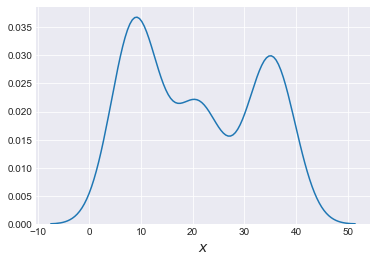

In [3]:
sns.kdeplot(np.array(mix))
plt.xlabel('$x$', fontsize=14)
plt.savefig('B04958_07_01.png', dpi=300, figsize=[5.5, 5.5])

In [4]:
# Author: Thomas Boggs

import matplotlib.tri as tri
from functools import reduce
from matplotlib import ticker, cm

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        xy: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) /reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, nlevels=100, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        dist: A distribution instance with a `pdf` method.
        border (bool): If True, the simplex border is drawn.
        nlevels (int): Number of contours to draw.
        subdiv (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap=cm.Blues, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

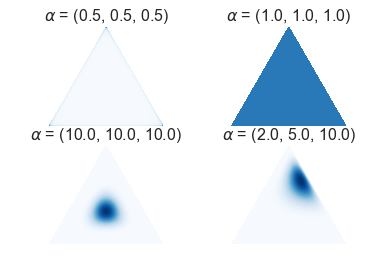

In [5]:
alphas = [[0.5] * 3, [1] * 3, [10] * 3, [2, 5, 10]]
for (i, alpha) in enumerate(alphas):
    plt.subplot(2, 2, i + 1)
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist)
    plt.title(r'$\alpha$ = ({:.1f}, {:.1f}, {:.1f})'.format(*alpha), fontsize=16)
    
plt.savefig('B04958_07_02.png', dpi=300, figsize=[5.5, 5.5])

In [6]:
with pm.Model() as model_kg:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # Known Gaussians means
    means = pm.math.constant([10, 20, 35])

    y = pm.Normal('y', mu=means[category], sd=2, observed=mix)

    trace_kg = pm.sample(1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p]
>CategoricalGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:42<00:00, 38.62draws/s] 


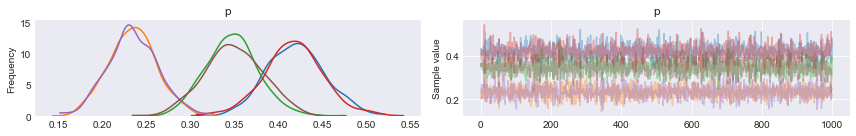

In [7]:
varnames_kg = ['p']
pm.traceplot(trace_kg, varnames_kg)
plt.savefig('B04958_07_03.png', dpi=300, figsize=[5.5, 5.5])

In [8]:
pm.summary(trace_kg, varnames_kg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p__0,0.418222,0.033833,0.000702,0.351557,0.485403,2251.887376,1.000861
p__1,0.233957,0.028132,0.000499,0.179791,0.290241,2753.382635,0.999604
p__2,0.347820,0.032064,0.000693,0.282802,0.408358,2183.884274,1.000399


In [9]:
with pm.Model() as model_ug:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # We estimate the unknown gaussians means and standard deviation
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)

    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)

    trace_ug = pm.sample(1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sd, means, p]
>CategoricalGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:57<00:00, 52.56draws/s]


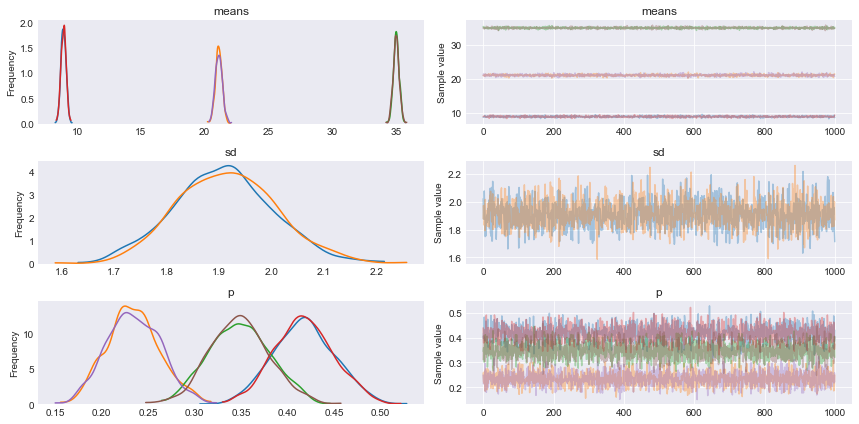

In [10]:
varnames_ug = ['means', 'sd', 'p']
pm.traceplot(trace_ug, varnames_ug)
plt.savefig('B04958_07_05.png', dpi=300, figsize=[5.5, 5.5])

In [11]:
pm.summary(trace_ug, varnames_ug)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,8.928170,0.199073,0.003746,8.534130,9.297581,2341.586001,0.999561
means__1,21.104916,0.267590,0.005670,20.585438,21.639907,2381.821395,0.999500
means__2,35.023026,0.226342,0.004617,34.565368,35.441994,2789.935372,0.999937
sd,1.910858,0.094853,0.001987,1.708030,2.082742,2442.198048,1.001229
p__0,0.417500,0.032095,0.000597,0.358027,0.481875,2551.100652,0.999510
p__1,0.234305,0.028440,0.000512,0.176580,0.287499,2846.757075,0.999511
p__2,0.348195,0.032137,0.000589,0.287212,0.412486,2786.524546,0.999538


In [12]:
ppc = pm.sample_posterior_predictive(trace_ug, 50, model_ug)

100%|██████████| 50/50 [00:00<00:00, 555.63it/s]


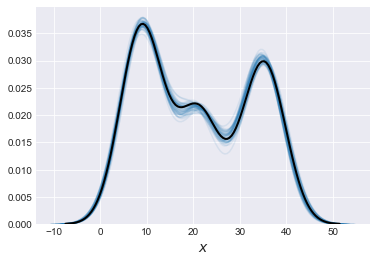

In [13]:
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='C0')

sns.kdeplot(np.array(mix), lw=2, color='k') # you may want to replace this with the posterior mean
plt.xlabel('$x$', fontsize=14)

plt.savefig('B04958_07_06.png', dpi=300, figsize=[5.5, 5.5])

## Marginalized Gaussian Mixture model

In [14]:
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)

    trace_mg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, means, p]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:11<00:00, 983.81draws/s]


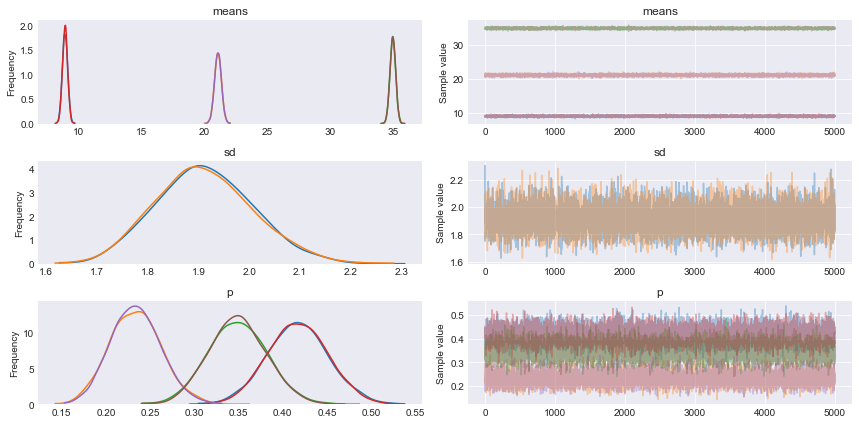

In [15]:
chain_mg = trace_mg[:]
varnames_mg = ['means', 'sd', 'p']
pm.traceplot(chain_mg, varnames_mg);

## Zero inflated Poisson model

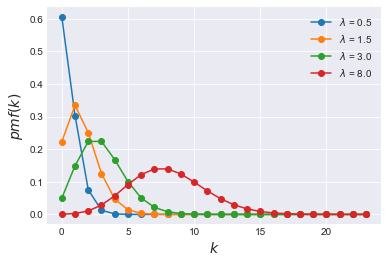

In [16]:
lam_params = [0.5, 1.5, 3, 8]
k = np.arange(0, max(lam_params) * 3)
for lam in lam_params:
    y = stats.poisson(lam).pmf(k)
    plt.plot(k, y, 'o-', label="$\\lambda$ = {:3.1f}".format(lam))
plt.legend()
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$pmf(k)$', fontsize=14)
plt.savefig('B04958_07_07.png', dpi=300, figsize=(5.5, 5.5))

In [17]:
np.random.seed(42)
n = 100
theta = 2.5  # Poisson rate
pi = 0.1  # probability of extra-zeros (pi = 1-psi)

# Simulate some data
counts = np.array([(np.random.random() > pi) * np.random.poisson(theta) for i in range(n)])

In [18]:
#plt.hist(counts, bins=30);

In [19]:
with pm.Model() as ZIP:
    psi = pm.Beta('psi', 1, 1)
    lam = pm.Gamma('lam', 2, 0.1)
    
    y = pm.ZeroInflatedPoisson('y', psi, lam, observed=counts)
    trace_ZIP = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, psi]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2393.18draws/s]


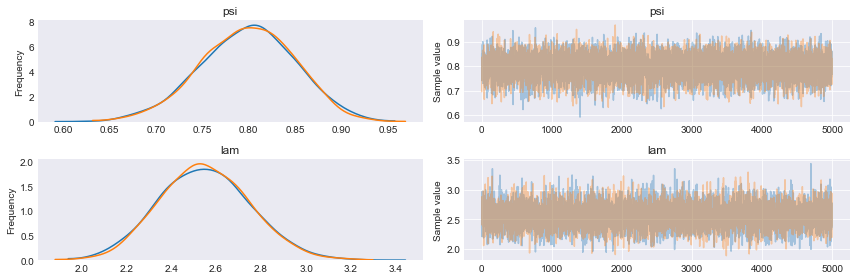

In [20]:
pm.traceplot(trace_ZIP);
plt.savefig('B04958_07_08.png', dpi=300, figsize=(5.5, 5.5))

In [21]:
pm.summary(trace_ZIP)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
psi,0.798816,0.050405,0.000502,0.697080,0.893541,8255.364668,0.999908
lam,2.550451,0.201863,0.002059,2.156719,2.936432,8171.898629,0.999939


## Zero inflated Poisson regression

In [22]:
#Kruschke plot

In [23]:
fish_data = pd.read_csv('../../../code/data/fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [24]:
#plt.hist(fish_data['count'], bins=20);

In [25]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi', 1, 1)
    
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10, shape=2)
    lam = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    
    y = pm.ZeroInflatedPoisson('y', psi, lam, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, psi]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 722.82draws/s] 


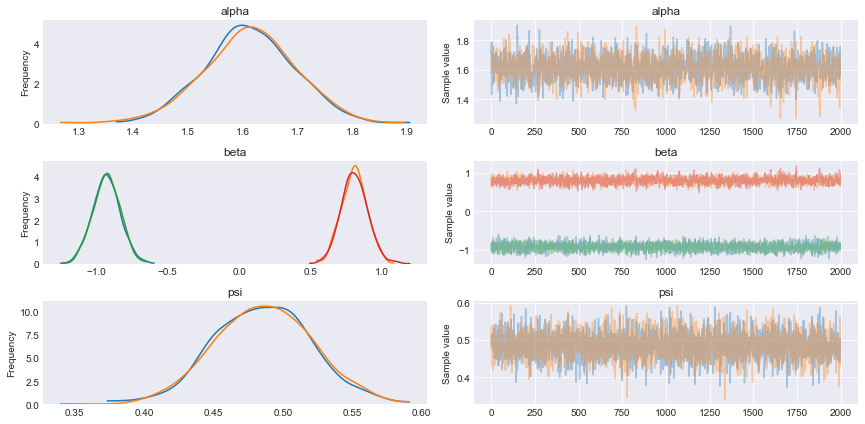

In [26]:
pm.traceplot(trace_ZIP_reg)
plt.savefig('B04958_07_10.png', dpi=300, figsize=(5.5, 5.5));

In [27]:
pm.summary(trace_ZIP_reg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.611237,0.083235,0.002015,1.448025,1.770872,1649.031578,0.999753
beta__0,-0.929433,0.095530,0.001579,-1.129337,-0.758148,3355.666760,0.999795
beta__1,0.807311,0.091000,0.002203,0.633335,0.986010,1638.823781,0.999860
psi,0.485210,0.035219,0.000611,0.418998,0.556742,3421.357220,0.999985


In [28]:
children =  [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
thin = 5
for n in children:
    without_camper = trace_ZIP_reg['alpha'][::thin] + trace_ZIP_reg['beta'][:,0][::thin] * n
    with_camper = without_camper + trace_ZIP_reg['beta'][:,1][::thin]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

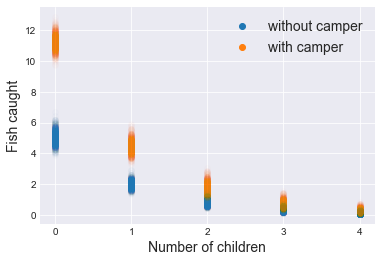

In [29]:
plt.plot(children, fish_count_pred_0, 'C0o', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C1o', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children', fontsize=14)
plt.ylabel('Fish caught', fontsize=14)
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend(fontsize=14)
plt.savefig('B04958_07_11.png', dpi=300, figsize=(5.5, 5.5))

## Robust logistic Regression

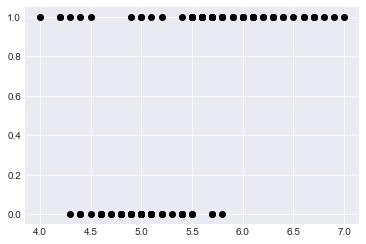

In [30]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_0_m = x_0 - x_0.mean()
plt.plot(x_0, y_0, 'o', color='k')
plt.savefig('B04958_07_12.png', dpi=300, figsize=(5.5, 5.5))

In [31]:
with pm.Model() as model_rlg:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha_tmp + beta * x_0_m
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    pi = pm.Beta('pi', 1, 1)
    p = pi * 0.5 + (1 - pi) * theta
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_0.mean())
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    
    trace_rlg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pi, beta, alpha_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 1811.87draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


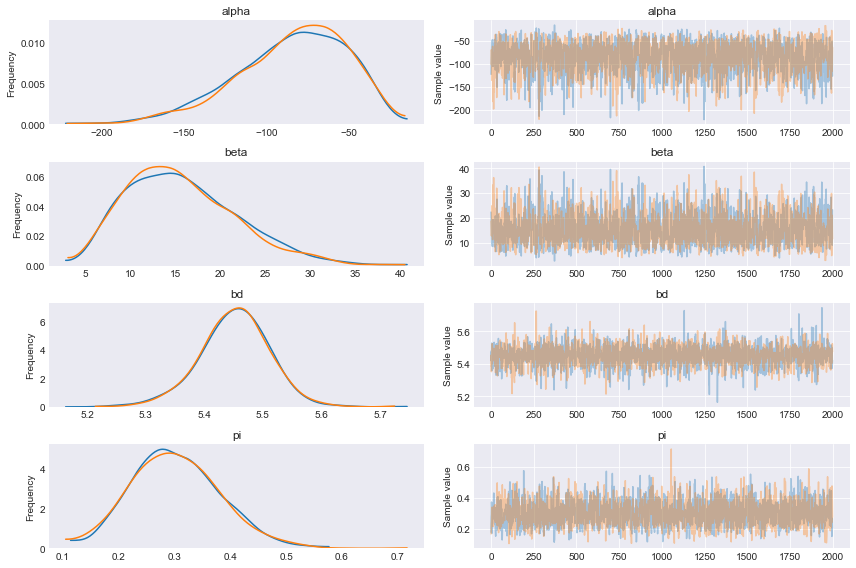

In [32]:
varnames = ['alpha', 'beta', 'bd', 'pi']
pm.traceplot(trace_rlg, varnames)
plt.savefig('B04958_07_13.png', dpi=300, figsize=(5.5, 5.5))

In [33]:
pm.summary(trace_rlg, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-85.379245,33.587873,0.829909,-153.672668,-29.624482,1445.118388,1.000448
beta,15.659373,6.152892,0.151641,5.140133,27.779705,1456.708188,1.000454
bd,5.450757,0.058885,0.001078,5.326554,5.558278,2659.093385,0.999792
pi,0.301709,0.078372,0.001651,0.149156,0.451799,1910.139893,1.000005


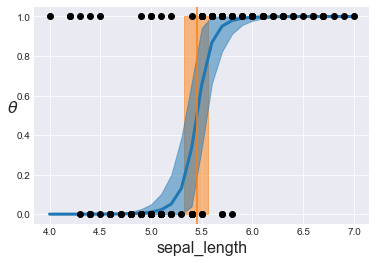

In [34]:
theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='C0', lw=3);
plt.axvline(trace_rlg['bd'].mean(), ymax=1, color='C1')
bd_hpd = pm.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_rlg['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='C0', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel('$\\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_07_14.png', dpi=300, figsize=(5.5, 5.5))

In [35]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.6.7
IPython 7.0.1
PyMC3 3.6.rc1
NumPy 1.14.2
SciPy 1.1.0
Matplotlib 3.0.2
Seaborn 0.9.0
Pandas 0.23.4
